<a href="https://colab.research.google.com/github/Melobgn/multi_modal/blob/main/multi_inputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
# Lister les fichiers pour confirmer l'accès
os.listdir('/content/drive/MyDrive/Flipkart')

['flipkart_com-ecommerce_sample_1050.csv',
 '.~lock.flipkart_com-ecommerce_sample_1050.csv#',
 'Images',
 'NLP_model',
 'NLP_tokenizer',
 'NLP_trainer']

In [ ]:
!pip install transformers
!pip install pandas
!pip install tensorflow
!pip install torch
!pip install scikit-learn
!pip install datasets evaluate
!pip install numpy
!pip install keras
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.8 MB/s eta 0:00:00


# ETAPE 1 : NLP AVEC HUGGINGFACE TRANSFORMERS TEXT CLASSIFICATION DISTILBERT

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Flipkart/flipkart_com-ecommerce_sample_1050.csv')
descriptions = df['description']
# Extraire la première catégorie
df['first_category'] = df['product_category_tree'].apply(lambda x: x.split('>>')[0].strip())
# Nettoyer la colonne en enlevant les guillemets doubles
df['first_category'] = df['first_category'].str.strip("[]").str.replace("'", "").str.replace('"', '').str.strip()

# Afficher la colonne sans les indices
print(df['first_category'].to_string(index=False))


           Home Furnishing
                 Baby Care
                 Baby Care
           Home Furnishing
           Home Furnishing
                   Watches
                   Watches
                   Watches
                   Watches
                   Watches
                   Watches
                   Watches
                   Watches
                   Watches
                   Watches
                   Watches
                   Watches
                   Watches
                   Watches
                   Watches
                   Watches
                   Watches
                   Watches
                   Watches
                   Watches
                   Watches
                   Watches
                   Watches
                   Watches
                   Watches
                   Watches
                   Watches
                   Watches
           Home Furnishing
           Home Furnishing
           Home Furnishing
Home Decor & Festive Needs
 

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import tensorflow as tf
import torch
import evaluate
from sklearn.metrics import precision_recall_fscore_support
import numpy as np


train_texts, val_texts, train_labels, val_labels = train_test_split(df['description'], df['first_category'], test_size=0.2, random_state=42)

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased-finetuned-sst-2-english")

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, return_tensors="pt")
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, return_tensors="pt")

# Convertir les catégories en labels numériques

unique_categories = df['first_category'].unique()
category_to_id = {cat: idx for idx, cat in enumerate(unique_categories)}

# S'assurer que le nombre de labels correspond au nombre de catégories uniques
num_labels = len(unique_categories)
print(f"Nombre de catégories uniques : {num_labels}")

train_labels = torch.tensor([category_to_id[label] for label in train_labels])
val_labels = torch.tensor([category_to_id[label] for label in val_labels])

# Charger la métrique accuracy
accuracy = evaluate.load("accuracy")

# Définir compute_metrics en dehors de CustomDataset
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Calculer accuracy
    acc = accuracy.compute(predictions=predictions, references=labels)

    # Calculer précision, rappel et F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    return {
        'accuracy': acc['accuracy'],
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Créer des datasets pour Trainer

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)

# Charger le modèle
model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased-finetuned-sst-2-english", num_labels=num_labels, ignore_mismatched_sizes=True)

# Geler les premières couches
for name, param in model.named_parameters():
    if "distilbert.embeddings" in name:  # Par exemple, geler les couches d'embeddings
        param.requires_grad = False

#Configuration d'entraînement

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8
)

# Utilisation du Trainer pour l'entraînement
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Entraînement du modèle
trainer.train()

# # Fonction pour extraire les caractéristiques du modèle DistilBERT
# def extract_features_from_bert(model, encodings):
#     model.eval()  # Mode évaluation
#     with torch.no_grad():
#         outputs = model(**encodings)
#     return outputs.last_hidden_state[:, 0, :].cpu().numpy()  # Extraire le vecteur CLS

# # Extraire les caractéristiques pour l'entraînement et la validation
# train_text_features = extract_features_from_bert(model, train_encodings)
# val_text_features = extract_features_from_bert(model, val_encodings)

# Sauvegarder le modèle entraîné
model.save_pretrained("/content/drive/MyDrive/Flipkart/NLP_model")
tokenizer.save_pretrained("/content/drive/MyDrive/Flipkart/NLP_tokenizer")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Nombre de catégories uniques : 7


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased-finetuned-sst-2-english and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.389719,0.904762,0.904127,0.904762,0.902137
2,No log,0.202797,0.938095,0.937417,0.938095,0.936867
3,No log,0.163338,0.952381,0.954765,0.952381,0.951469


('/content/drive/MyDrive/Flipkart/NLP_tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/Flipkart/NLP_tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/Flipkart/NLP_tokenizer/vocab.txt',
 '/content/drive/MyDrive/Flipkart/NLP_tokenizer/added_tokens.json',
 '/content/drive/MyDrive/Flipkart/NLP_tokenizer/tokenizer.json')

# **ETAPE 2 : COMPUTER VISION AVEC EFFICIENTNET**

In [ ]:
import random
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import os
import shutil
import pandas as pd
import numpy as np

# Chemin vers le répertoire contenant les images
base_dir = '/content/drive/MyDrive/Flipkart/Images'

# Créer les sous-dossiers de catégories s'ils n'existent pas
for category in df['first_category'].unique():
    os.makedirs(os.path.join(base_dir, category), exist_ok=True)

# Déplacer chaque image dans le dossier de sa catégorie
for _, row in df.iterrows():
    src_path = os.path.join(base_dir, row['image'])  # chemin d'origine de l'image
    dest_path = os.path.join(base_dir, row['first_category'], row['image'])  # chemin de destination
    if os.path.exists(src_path):  # vérifier si le fichier existe pour éviter les erreurs
        shutil.move(src_path, dest_path)
    else:
        print(f"Image non trouvée : {src_path}")

print("Images regroupées par catégorie.")


NameError: name 'df' is not defined

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Configuration du générateur de données avec augmentation avancée
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Générateurs d'images
train_generator = datagen.flow_from_directory(
    directory=base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)
validation_generator = datagen.flow_from_directory(
    directory=base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)

# Charger EfficientNet et geler les premières couches
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[:100]:
    layer.trainable = False

# Ajouter des couches de classification avec Dropout et régularisation L2
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

# Créer le modèle final
model = Model(inputs=base_model.input, outputs=output)

# Compiler le modèle avec des callbacks pour le contrôle du taux d’apprentissage
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Définir les callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Entraîner le modèle
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stopping, lr_reduction]
)

# Fonction pour extraire les caractéristiques visuelles avec EfficientNet
def extract_image_features(generator, model):
    features = []
    labels = []
    for inputs, label in generator:
        feature = model.predict(inputs)
        features.append(feature)
        labels.append(label)
        if len(features) >= generator.samples // generator.batch_size:  # Sortir une fois tous les batches traités
            break
    return np.vstack(features), np.vstack(labels)

# Extraire les caractéristiques pour l'entraînement et la validation
train_image_features, train_labels = extract_image_features(train_generator, base_model)
val_image_features, val_labels = extract_image_features(validation_generator, base_model)

# Sauvegarder le modèle EfficientNet
model.save("/content/drive/MyDrive/Flipkart/EfficientNet_model.h5")


NameError: name 'base_dir' is not defined

In [ ]:
# Afficher les scores pour chaque époque
for epoch, acc, val_acc, loss, val_loss in zip(
        range(1, len(history.history['accuracy']) + 1),
        history.history['accuracy'],
        history.history['val_accuracy'],
        history.history['loss'],
        history.history['val_loss']):
    print(f"Époque {epoch}: Précision - Entraînement = {acc:.4f}, Validation = {val_acc:.4f}")
    print(f"Époque {epoch}: Perte - Entraînement = {loss:.4f}, Validation = {val_loss:.4f}")


Époque 1: Précision - Entraînement = 0.1333, Validation = 0.1429
Époque 1: Perte - Entraînement = 2.2678, Validation = 2.1730
Époque 2: Précision - Entraînement = 0.1357, Validation = 0.1429
Époque 2: Perte - Entraînement = 2.2078, Validation = 2.2324
Époque 3: Précision - Entraînement = 0.1202, Validation = 0.1429
Époque 3: Perte - Entraînement = 2.1916, Validation = 2.3057
Époque 4: Précision - Entraînement = 0.1298, Validation = 0.1429
Époque 4: Perte - Entraînement = 2.1683, Validation = 2.1982
Époque 5: Précision - Entraînement = 0.1429, Validation = 0.1429
Époque 5: Perte - Entraînement = 2.1485, Validation = 2.1617
Époque 6: Précision - Entraînement = 0.1429, Validation = 0.1429
Époque 6: Perte - Entraînement = 2.1357, Validation = 2.1345
Époque 7: Précision - Entraînement = 0.1583, Validation = 0.1429
Époque 7: Perte - Entraînement = 2.1293, Validation = 2.1320
Époque 8: Précision - Entraînement = 0.1369, Validation = 0.1429
Époque 8: Perte - Entraînement = 2.1258, Validation =

In [ ]:
# Évaluer le modèle sur les données de validation
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Score final - Perte (validation): {val_loss:.4f}")
print(f"Score final - Précision (validation): {val_accuracy:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.1644 - loss: 1.9962
Score final - Perte (validation): 1.9964
Score final - Précision (validation): 0.1429


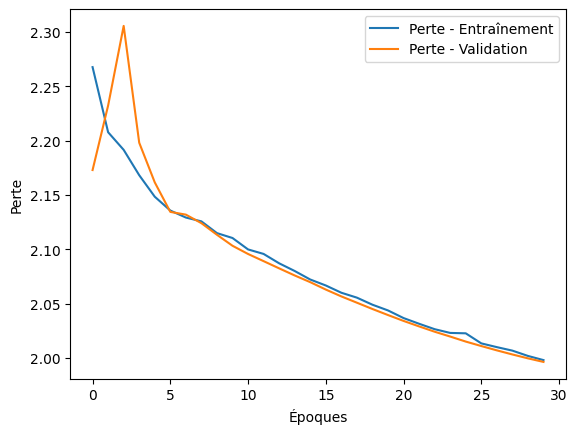

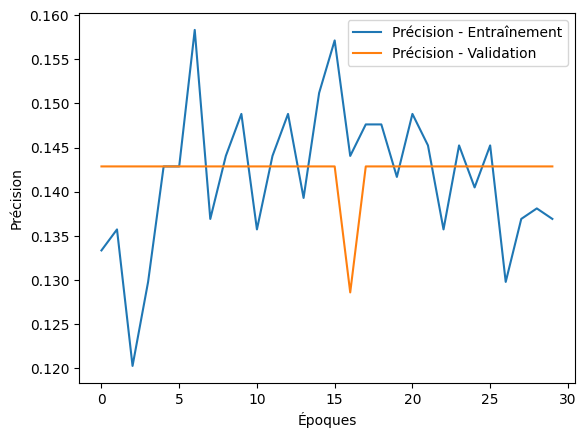

In [ ]:
import matplotlib.pyplot as plt

# Afficher la perte
plt.plot(history.history['loss'], label='Perte - Entraînement')
plt.plot(history.history['val_loss'], label='Perte - Validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.show()

# Afficher la précision
plt.plot(history.history['accuracy'], label='Précision - Entraînement')
plt.plot(history.history['val_accuracy'], label='Précision - Validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()
plt.show()

# **ETAPE 3 : MODELE MULTI-INPUTS**

In [20]:
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from transformers import TFDistilBertModel, DistilBertTokenizer
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
import os
import tensorflow as tf

# Chemin des données et dossier images
data_path = '/content/drive/MyDrive/Flipkart/flipkart_com-ecommerce_sample_1050.csv'
image_folder = '/content/drive/MyDrive/Flipkart/Images'
max_length = 200  # Longueur max pour les descriptions

# Chargement des données
df = pd.read_csv(data_path)
df['first_category'] = df['product_category_tree'].apply(lambda x: x.split('>>')[0].strip())
df['first_category'] = df['first_category'].str.strip("[]").str.replace("'", "").str.replace('"', '').str.strip()

# Prétraitement des descriptions avec DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert/distilbert-base-uncased-finetuned-sst-2-english')

def preprocess_text(descriptions, tokenizer, max_length):
    return tokenizer(descriptions.tolist(), padding=True, truncation=True, max_length=max_length, return_tensors='tf')

descriptions = preprocess_text(df['description'], tokenizer, max_length)

# Prétraitement des images avec MobileNetV2
def load_and_process_images(image_names, image_folder, target_size=(160, 160)):
    image_data = []
    for img_name in image_names:
        img_path = os.path.join(image_folder, img_name)
        try:
            img = image.load_img(img_path, target_size=target_size)
            img_array = image.img_to_array(img)
            image_data.append(img_array)
        except FileNotFoundError:
            print(f"Image {img_name} non trouvée, ignorée.")
            image_data.append(np.zeros((target_size[0], target_size[1], 3)))  # Placeholder si image manquante
    return np.array(image_data)

image_data = load_and_process_images(df['image'], image_folder)

# Conversion des catégories en labels numériques
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['first_category'])

# Modèle texte (DistilBERT)
text_input = Input(shape=(max_length,), dtype=tf.int32, name='text')
text_model = TFDistilBertModel.from_pretrained('distilbert/distilbert-base-uncased-finetuned-sst-2-english')
for layer in text_model.layers:
    layer.trainable = False  # Geler les couches
text_output = tf.keras.layers.Lambda(lambda x: text_model(x)[0][:, 0, :], output_shape=(768,))(text_input)
text_output = Dense(64, activation='relu')(text_output)  # Réduire la dimension de sortie

# Modèle image (MobileNetV2)
image_input = Input(shape=(160, 160, 3), name='image')
image_model = MobileNetV2(include_top=False, pooling='avg')
for layer in image_model.layers:
    layer.trainable = False  # Geler les couches
image_output = image_model(image_input)
image_output = Dense(64, activation='relu')(image_output)

# Combinaison des modèles texte et image
combined = Concatenate()([text_output, image_output])
output = Dense(len(df['first_category'].unique()), activation='softmax')(combined)

# Modèle final
multi_input_model = Model(inputs=[text_input, image_input], outputs=output)
multi_input_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
multi_input_model.fit(
    [descriptions['input_ids'], image_data], labels,
    epochs=5,
    batch_size=16,
    validation_split=0.2
)

# Évaluation
loss, accuracy = multi_input_model.evaluate([descriptions['input_ids'], image_data], labels)
print(f"Loss: {loss}, Accuracy: {accuracy}")

multi_input_model.save('model/multi_input_model.h5')



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Image 55b85ea15a1536d46b7190ad6fff8ce7.jpg non trouvée, ignorée.
Image 7b72c92c2f6c40268628ec5f14c6d590.jpg non trouvée, ignorée.
Image 64d5d4a258243731dc7bbb1eef49ad74.jpg non trouvée, ignorée.
Image d4684dcdc759dd9cdf41504698d737d8.jpg non trouvée, ignorée.
Image 6325b6870c54cd47be6ebfbffa620ec7.jpg non trouvée, ignorée.
Image 893aa5ed55f7cff2eccea7758d7a86bd.jpg non trouvée, ignorée.
Image f355cc1ccb08bd0d283ed979b7ee7515.jpg non trouvée, ignorée.
Image dd0e3470a7e6ed76fd69c2da27721041.jpg non trouvée, ignorée.
Image 41384da51732c0b4df3de8f395714fbb.jpg non trouvée, ignorée.
Image 710ed5f2393a4b9e8823aa0029f71f93.jpg non trouvée, ignorée.
Image 920154acbe49d3202ed7d2ed2df1ea13.jpg non trouvée, ignorée.
Image 08452abdadb3db1e686b94a9c52fc7b6.jpg non trouvée, ignorée.
Image 1e8741b5ae27a513546c94b3f3312aee.jpg non trouvée, ignorée.
Image 189fa66a5fa6f08d2802a62ecf0be298.jpg non trouvée, ignorée.
Image bbb8cdc5406ff60ff06ff64630f2ca47.jpg non trouvée, ignorée.
Image 1120bc768623572513d

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
<ipython-input-20-713eaf3362e6>:60: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [9

Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 549s 10s/step - accuracy: 0.2828 - loss: 1.8692 - val_accuracy: 0.2143 - val_loss: 1.9070
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 567s 10s/step - accuracy: 0.5165 - loss: 1.4322 - val_accuracy: 0.4000 - val_loss: 1.6627
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 559s 10s/step - accuracy: 0.5927 - loss: 1.2234 - val_accuracy: 0.3762 - val_loss: 1.6838
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 557s 9s/step - accuracy: 0.6440 - loss: 1.0500 - val_accuracy: 0.4619 - val_loss: 1.4390
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 498s 9s/step - accuracy: 0.7353 - loss: 0.8849 - val_accuracy: 0.4762 - val_loss: 1.4885
33/33 ━━━━━━━━━━━━━━━━━━━━ 459s 14s/step - accuracy: 0.7808 - loss: 0.8961


Loss: 1.0123921632766724, Accuracy: 0.715238094329834


In [21]:
multi_input_model.save('model/multi_input_model.h5')

# **ETAPE CREATION D'UNE API**

In [18]:
!pip install fastapi uvicorn
!pip install python-multipart

In [22]:
from fastapi import FastAPI, UploadFile, File
from pydantic import BaseModel
from tensorflow.keras.models import load_model
from transformers import DistilBertTokenizer
from tensorflow.keras.preprocessing import image as keras_image
import tensorflow as tf
import numpy as np
import os


# Initialisation de FastAPI
app = FastAPI()

# Chargement du modèle et du tokenizer
model = load_model('model/multi_input_model.h5')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Paramètres pour l'image
IMAGE_SIZE = (160, 160)

# Modèle de données pour l'entrée JSON
class PredictRequest(BaseModel):
    description: str

def preprocess_text(description, tokenizer, max_length=200):
    tokens = tokenizer(description, padding='max_length', truncation=True, max_length=max_length, return_tensors="tf")
    return tokens['input_ids']

def preprocess_image(uploaded_file):
    img = keras_image.load_img(uploaded_file, target_size=IMAGE_SIZE)
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Ajouter une dimension pour le batch
    return img_array

@app.post("/predict/")
async def predict(request: PredictRequest, file: UploadFile = File(...)):
    # Prétraitement de la description
    text_input = preprocess_text(request.description, tokenizer)

    # Sauvegarde temporaire de l'image
    img_path = f"images/{file.filename}"
    with open(img_path, "wb") as buffer:
        buffer.write(await file.read())

    # Prétraitement de l'image
    image_input = preprocess_image(img_path)
    os.remove(img_path)  # Nettoyage de l'image après traitement

    # Prédiction
    prediction = model.predict([text_input, image_input])
    predicted_category = np.argmax(prediction, axis=1)[0]

    return {"predicted_category": int(predicted_category)}


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
